Мы работаем  в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи нашего мобильного приложения. Для этого - изучить результаты А/А/В теста по изменению шрифтов в приложении. После - уже дать рекомендации коллегам

Будем придерживаться селдующего плана:
- [изучим общую информацию](#general)
- [подготовим данные для анализа](#prep)
- [изучим и проверим данные](#check)
- [исследуем воронку событий](#funnel)
- [изучим результаты эксперимента](#experiment)
- [предоставим рекомендации коллегам](#output)

## Общая информация
<a id='general'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express  as  px 
from plotly import graph_objects as go
import warnings
warnings.filterwarnings('ignore')
from scipy import stats as st
from scipy.stats import norm
import math as mth


In [2]:
df = pd.read_csv('C:\\Users\\Александр\Datasets/logs_exp.csv', sep='\t')

In [3]:
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


## Подготовка данных
<a id='prep'></a>

Для дальнейшего удобства заменим названия столбцов во фрейме

In [5]:
df.columns = ['event_name', 'user_id', 'event_time', 'group']
#df.head()

Пропусков данных не наблюдаем. Проверим наличие дубликатов. По здравом размышлении, стоит проверить только полные дубликаты: каждому user_id может будет соответствовать несколько событий и тд

In [6]:
df.duplicated().sum()

413

In [7]:
volume_dubl = np.around((df.duplicated().sum() / len(df) * 100), decimals = 2)
volume_dubl

0.17

Количество полных дубликатов - менее 1%, удаляем их

In [8]:
df = df.drop_duplicates()
#df.info()

Обратим внимание на столбец со временем. На первый взгляд, значения выглядят странным. Но, видимо, это просто формат unix, который мы заменим на нужный нам. Типы данных в остальных столбцах нас устраивают

In [9]:
df['event_time'] = pd.to_datetime(df['event_time'], unit = 's')

Добавим столбец даты для удобства при расчетах

In [10]:
df['date'] = df['event_time'].dt.date


In [11]:
df.head()

,event_name,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
event_name    243713 non-null object
user_id       243713 non-null int64
event_time    243713 non-null datetime64[ns]
group         243713 non-null int64
date          243713 non-null object
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


Данные подготовлены, начнем их изучение

## Логическая проверка данных
<a id='check'></a>

### Количество событий в логе

In [13]:
df['event_name'].count()

243713

### Количество пользователей в логе

In [14]:
df['user_id'].nunique()

7551

### Среднее количество событий

Посчитаем количество событий на каждого юзера с учетом его принадлежности к группе.

In [15]:
event_per_user = df.groupby(['user_id', 'group'])['event_name'].count().reset_index()
event_per_user.head()

,user_id,group,event_name
0,6888746892508752,246,1
1,6909561520679493,247,5
2,6922444491712477,246,47
3,7435777799948366,248,6
4,7702139951469979,247,137


In [16]:
event_per_user.groupby('group').agg({'user_id': 'nunique', 'event_name': ['mean', 'median']})

user_id event_name       
      nunique       mean median
group                          
246      2489  32.214142   19.0
247      2520  30.932540   19.5
248      2542  33.667191   20.0

Видим, что в среднем и медианном значении экспериментальная группа 248 опережает две контрольные - это говорит о чуть большей вовлеченности пользователей после изменений шрифтов

In [17]:
event_per_user_246 = event_per_user.query('group == 246')
event_per_user_247 = event_per_user.query('group == 247')
event_per_user_248 = event_per_user.query('group == 248')

In [18]:
event_per_user_248.describe()

,user_id,group,event_name
count,2.542000e+03,2542.0,2542.000000
mean,4.670207e+18,248.0,33.667191
std,2.635105e+18,0.0,72.931171
min,7.435778e+15,248.0,1.000000
25%,2.467279e+18,248.0,9.000000
50%,4.694145e+18,248.0,20.000000
75%,6.951457e+18,248.0,38.000000
max,9.222603e+18,248.0,2307.000000


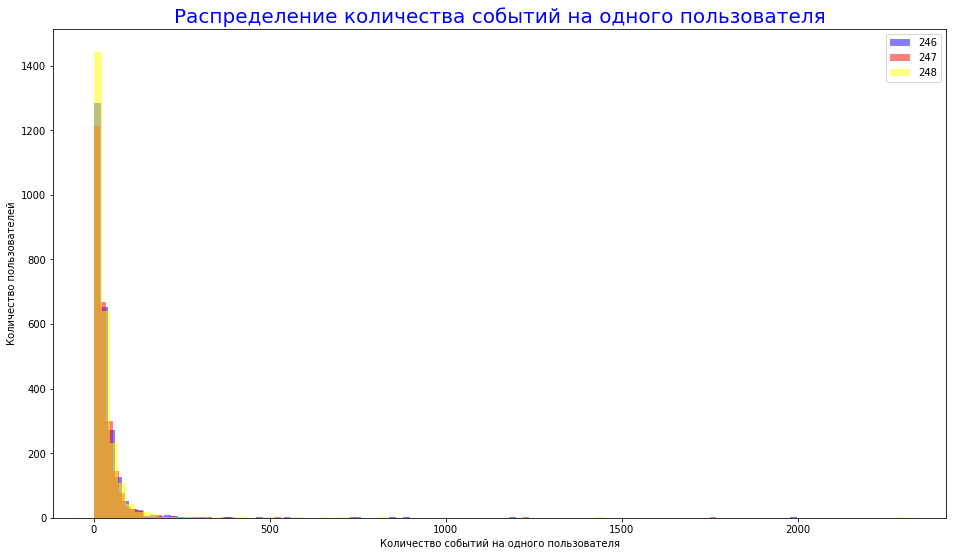

In [19]:
plt.figure(figsize=(16,9))
#plt.ylim(0, 800)
plt.hist(event_per_user_246['event_name'], bins=100, alpha=0.5, label='246', color='blue')
plt.hist(event_per_user_247['event_name'], bins=100, alpha=0.5, label='247', color='red')
plt.hist(event_per_user_248['event_name'], bins=100, alpha=0.5, label='248', color='yellow')
plt.legend(loc='upper right')
plt.title('Распределение количества событий на одного пользователя', color = 'blue', fontsize=20)
plt.xlabel('Количество событий на одного пользователя')
plt.ylabel('Количество пользователей')
plt.show()

Из графика видим, что есть дикие показатели по количеству событий на одного пользователя. Может быть, мы не корректно построили график? Но нет, все верно. Проверим распределение по перцентилям и описанию фрейма

In [20]:
display(np.percentile(event_per_user_248['event_name'], [50, 75, 90, 95, 99, 99.9]))

array([ 20.   ,  38.   ,  66.   ,  90.95 , 200.95 , 757.998])

In [21]:
event_per_user_246.describe()

,user_id,group,event_name
count,2.489000e+03,2489.0,2489.000000
mean,4.695161e+18,246.0,32.214142
std,2.681103e+18,0.0,65.085668
min,6.888747e+15,246.0,1.000000
25%,2.415898e+18,246.0,9.000000
50%,4.711967e+18,246.0,19.000000
75%,7.079811e+18,246.0,37.000000
max,9.221926e+18,246.0,1998.000000


Действительно, на примере группы 246 видим, что есть аномальные показатели. Возможно, это роботы / боты, которые совершают огромное количество действий / парсят приложение. Нужно дать знать разработчикам

### Актуальный период

Данными за какой период мы располагаем? Быть может, нам стоит актуализировать временной интервал для дальнейшего анализа?

In [22]:
df.head()

,event_name,user_id,event_time,group,date
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
event_name    243713 non-null object
user_id       243713 non-null int64
event_time    243713 non-null datetime64[ns]
group         243713 non-null int64
date          243713 non-null object
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


Видим, что данные у нас имеются за период с 25.07 по 07.08. Но насколько равномерно распределено количество событий в данный период?

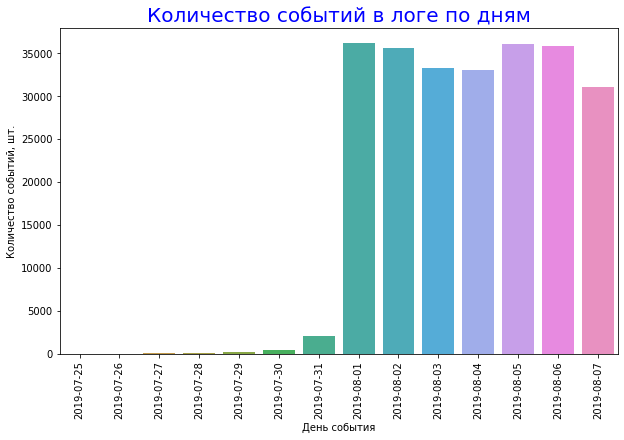

In [24]:
plt.figure(figsize=(10,6))
sns.barplot(x='date', y='event_name', data=df.groupby('date')['event_name'].count().reset_index())
plt.xticks(rotation=90)
plt.title('Количество событий в логе по дням', color = 'blue', fontsize=20)
plt.xlabel('День события')
plt.ylabel('Количество событий, шт.')
plt.show()

Есть подозрение, что технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это как раз и «перекашивает данные». С данного момента актуальным периодом для анализа считаем период с 01.08 по 07.08

Сколько же пользователей мы тогда потеряем?

In [25]:
# выделим тех пользователей, данные по которым есть только до нужной нам даты
before = df.query('date < datetime(2019, 8, 1).date()')
after = df.query('date >= datetime(2019, 8, 1).date()')
users_before_only = len(before.query('user_id not in @after.user_id')['user_id'].unique())
users_before_only

17

In [26]:
# процент потерянных пользователей
users_before_only / len(df['user_id'].unique())

0.0022513574361011784

In [27]:
after['group'].unique()

array([246, 247, 248])

В итоге в актуальные данных мы потеряли всего лишь 17 пользователей (в относительном выражении меньше одного процента) - это мы переживем) А главное - представители всех наших трех групп на месте. Далее работаем только с периодом от 1 августа

In [28]:
df = df.query('date >= datetime(2019, 8, 1).date()')

При расчетах мы увидели аномальное количество действий пользователя в день. Возможно, это связано с техническими проблемами, возможно - с деятельностью роботов. В обоих случаях стоит дать знать нашим коллегам из разработки. Также установили, что актуальным периодом будем считать период с 1 августа: именно тогда мы начали корректно собирать данные по юзерам

## Воронка событий
<a id='funnel'></a>

In [29]:
df.head()

,event_name,user_id,event_time,group,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


Проверим, сколько у нас уникальных пользователей и как они двигаются по воронке

In [30]:
funnel = df.groupby('event_name')['user_id'].nunique().reset_index().sort_values(by='user_id', ascending=False)
funnel

,event_name,user_id
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


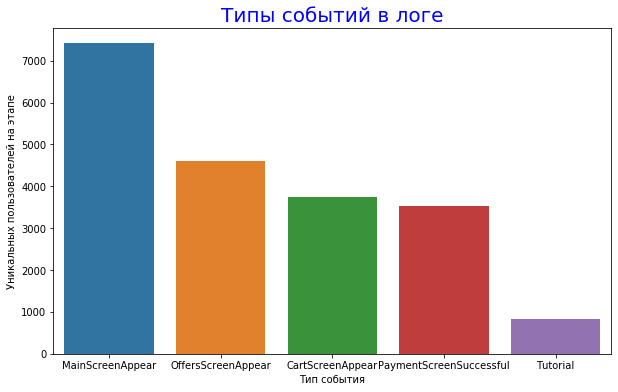

In [31]:
#df.sort_values(by='event_name', ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x='event_name', y='user_id', data=funnel)
plt.xticks(rotation=0)
plt.title('Типы событий в логе', color = 'blue', fontsize=20)
plt.xlabel('Тип события')
plt.ylabel('Уникальных пользователей на этапе')
plt.show()

Как видим, воронка хороша, начиная со второго этапа - просмотра предложения пользователем. Но почему так мало людей доходят до просмотра предложения? Нужно дать знать разработчикам: быть может, есть трудности для пользователя до данного этапа

In [32]:
funnel

,event_name,user_id
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


Теперь рассчитаем число уникальных пользователей, которые были на любом из этапов

In [33]:
funnel['absolute_%'] = funnel['user_id'] / df['user_id'].nunique()
funnel

,event_name,user_id,absolute_%
1,MainScreenAppear,7419,0.984736
2,OffersScreenAppear,4593,0.609636
0,CartScreenAppear,3734,0.495620
3,PaymentScreenSuccessful,3539,0.469737
4,Tutorial,840,0.111495


Интересно. А почему на главную приходит только 98,5% пользователей? Этот экран вроде нельзя пропустить в приложении. Думается, что эта проблема связана с тем, что была отброшена часть событий, которые были в июле. А там пользователи как раз проходили первый этап воронки. И уже в августе у них были новые этапы. Поэтому они считаются в униках, но их нет на первом этапе.

Чтобы посчитать отношение следующего этапа к предыдущему, добавим количество пользователей на предыдущем этапе и рассчитаем конверсию

In [34]:
funnel['user_id_prev'] = funnel['user_id'].shift(1)
funnel.loc[funnel['user_id'].isna(), 'user_id_prev'] = funnel.loc[funnel['user_id_prev'].isna(), 'user_id']
funnel['perc_prev'] = funnel['user_id'] / funnel['user_id_prev']
funnel

,event_name,user_id,absolute_%,user_id_prev,perc_prev
1,MainScreenAppear,7419,0.984736,NaN,NaN
2,OffersScreenAppear,4593,0.609636,7419.0,0.619086
0,CartScreenAppear,3734,0.495620,4593.0,0.812976
3,PaymentScreenSuccessful,3539,0.469737,3734.0,0.947777
4,Tutorial,840,0.111495,3539.0,0.237355


Думается, что tutorial мы можем не принимать в расчет потому, что основная цель воронки - оплата от клиента. На ней можно и закончить. Тогда самую низкую конверсию наблюдаем при переходе с главного экрана на экран с предложением. Стоит об этом сказать разработчикам / коллегам из UIX: возможно, кнопка ознакомления у нас нечетко видна, либо пользователю нужно много скроллить, чтобы до нее добраться. И доходят не все

А если говорить про конечную конверсию, то показатель в 47% выглядит очень даже хорошо. Далее как раз проверим, есть ли зависимость показателей от изменений шрифтов в приложении

## Результаты эксперимента
<a id='experiment'></a>

### Количество пользователей в группе

Итак, у нас есть 2 группы А и одна группа В. Для начала нужно понять, сколько пользователей в каждой группе

In [35]:
df.head()

,event_name,user_id,event_time,group,date
2828,Tutorial,3737462046622621720,2019-08-01 00:07:28,246,2019-08-01
2829,MainScreenAppear,3737462046622621720,2019-08-01 00:08:00,246,2019-08-01
2830,MainScreenAppear,3737462046622621720,2019-08-01 00:08:55,246,2019-08-01
2831,OffersScreenAppear,3737462046622621720,2019-08-01 00:08:58,246,2019-08-01
2832,MainScreenAppear,1433840883824088890,2019-08-01 00:08:59,247,2019-08-01


246 и 247 различаются чуть больше, чем на 1 процент - что вполне допустимо для целей нашего исследования. 

### Статистическая разница между выборками

Сначала пропишем функцию для определения разницы между выборками

In [36]:
def z_test(n1, x1, n2, x2, alpha):
    p1 = x1 / n1
    p2 = x2 / n2
    p = (p1 * n1 + p2 * n2) /(n1 + n2)
    SE = np.sqrt(p * (1 - p) * (1/n1 + 1/n2))
    m = SE * norm.ppf(1 - alpha/2)    
    z_stat = (p1 - p2)/SE
    p = norm.cdf(np.abs(z_stat))
    return 2 * (1 - p)

Теперь сравним статразницу между 246 и 247 группами.


H0: статистически значимая разница между группами отсутствует

H1: есть статистически значимая разница

In [37]:
event = df.copy()
event = event.query('event_name!="Tutorial"')
# сменим имена групп на строки
event['group'] = event['group'].astype(str) 

# посчитаем общее количество пользователей в группах
totals = event.groupby('group').agg({'user_id': 'nunique'})['user_id']
display(totals)

# создадим сводник
countsi = event.pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique').reset_index()
countsi = countsi.sort_values(by='246',ascending=False)
# для расчета конверсии просто подставим значения из totals
countsi['prev%246'] = countsi['246'] / 2483 
countsi['prev%247'] = countsi['247'] / 2512
countsi['prev%248'] = countsi['248'] / 2535
#display(countsi)

# в коррекции уроня значимости учтем все шаги
countsi['alpha'] = 0.05 / (countsi.shape[0] * 2)

# добавим столбец с p_value как раз с помощью созданной нами функции
countsi['p-value'] = countsi.apply(lambda x: z_test(totals['246'], x['246'], totals['247'], x['247'], countsi['alpha']), axis = 1)
countsi

group
246    2483
247    2512
248    2535
Name: user_id, dtype: int64

group,event_name,246,247,248,prev%246,prev%247,prev%248,alpha,p-value
1,MainScreenAppear,2450,2476,2493,0.986710,0.985669,0.983432,0.00625,0.752670
2,OffersScreenAppear,1542,1520,1531,0.621023,0.605096,0.603945,0.00625,0.247861
0,CartScreenAppear,1266,1238,1230,0.509867,0.492834,0.485207,0.00625,0.228676
3,PaymentScreenSuccessful,1200,1158,1181,0.483286,0.460987,0.465878,0.00625,0.114466


При любом сравнении мы наблюдаем p_value больше alpha, поэтому не можем отвергнуть нулевую гипотезу об отстутствии разницы между группами 246 и 247

In [38]:
# считаем, что 246 и 247 эквиваленты
events = df.copy()
events = events.query('event_name!="Tutorial"')
events['group'] = events['group'].astype(str).str.replace('246|247', 'A').str.replace('248', 'B')
# количество уников
totals = events.groupby('group').agg({'user_id': 'nunique'})['user_id']
display(totals)
counts = events.pivot_table(index = 'event_name', columns = 'group', values = 'user_id', aggfunc = 'nunique')
#коррекция уровня значимости 
counts['alpha'] = 0.05 / (counts.shape[0] * 2)
counts['p-value'] = counts.apply(lambda x: z_test(totals['A'], x['A'], totals['B'], x['B'], counts['alpha']), axis = 1)
counts

group
A    4995
B    2535
Name: user_id, dtype: int64

group,A,B,alpha,p-value
event_name,,,,
CartScreenAppear,2504,1230,0.00625,0.186836
MainScreenAppear,4926,2493,0.00625,0.348668
OffersScreenAppear,3062,1531,0.00625,0.445827
PaymentScreenSuccessful,2358,1181,0.00625,0.610792


При сравнении групп А и В видим аналогичную картину: p_value больше alpha, поэтому не можем отвергнуть нулевую гипотезу об отстутствии разницы между группами А и В

## Вывод

Проведя анализ данных, мы разобрались, как ведут себя пользователи нашего мобильного приложения. Для этого мы изучили результаты А/А/В теста по изменению шрифтов в приложении. И прили к выводу, что изменение шрифтов не оказало влияние в положительную сторону. Тест успешным признать нельзя.

Дополнительно можем сказать следующее:
- наткнулись на аномальные случаи, когда на одного пользователяприходится около 200 событий: возможно, это связано с деятельностью роботов/парсеров
- данные подгружались нам неравномерно: основной массив подъехал 01.08, поэтому за основу для анализа взяли именно период с 01.08
- по воронке тоже есть заметка: нашим UX/UI и технарям рекомендуем проверить как со стороны пользовательского опыта, так и с технической стороны - почему общая конверсия на экран просмотра предложения составляет 61% и почему такое малое количество пользователей (11%) ознакамливаются с руководством к пользованию
- что касается самого эксперимента, то его успешным признать нельзя: ни в одном случае мы не можем наблюдать статистически значимые изменения в положительную сторону